In [1]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import numpy as np

In [2]:
def tokenize(text):
    pattern = word_tokenize(text)
    return pattern

In [3]:
def mapping(tokens):
    wordToIndex = dict()
    indexToWord = dict()

    for i, token in enumerate(set(tokens)):
        wordToIndex[token] = i
        indexToWord[i] = token
    return wordToIndex, indexToWord

In [4]:
def generateData(tokens, wordToIndex, context_size):
    length = len(tokens)
    x, y = [], []

    for i in range(length):
        nbr_inds = list(range(max(0, i - context_size), i)) + \
                   list(range(i + 1, min(length, i + context_size + 1)))
        for j in nbr_inds:
            x.append(wordToIndex[tokens[i]])
            y.append(wordToIndex[tokens[j]])
            
    x = np.array(x)
    x = np.expand_dims(x, axis=0)
    y = np.array(y)
    y = np.expand_dims(y, axis=0)

    return x, y

In [5]:
s = "Lionel Messi is the greatest footballer to ever grace the pitch."
tokens = tokenize(s)
word_to_index, index_to_word = mapping(tokens)
x, y = generateData(tokens, word_to_index, 5)
#x corresponds to the index of the word(in word_to_index) while its corresponding element in y 
#is one of its context words (x is the centre)
vocabulary_size = len(index_to_word)
m = y.shape[1]

In [6]:
#y_oh is one hot vector 
y_oh = np.zeros((vocabulary_size, m))
y_oh[y.flatten(), np.arange(m)] = 1
#y_oh has shape (11, 90). the first row corresponds to word_to_index's first element (here, 'the') and the number of ones
#for each row is equal to the number of context words all of its(the word's) occurences have combined

In [7]:
def initialize_word_embeddings(vocabulary_size, dimension):
    
    word_embedding = np.random.randn(vocabulary_size, dimension) * 0.01
    assert(word_embedding.shape == (vocabulary_size, dimension))
    return word_embedding

In [8]:
def initialize_dense_layer(input_size, output_size):
    
    dense = np.random.randn(output_size, input_size) * 0.01
    assert(dense.shape == (output_size, input_size))
    return dense

In [9]:
def initialize_parameters(vocabulary_size, dimension):
    
    word_embedding = initialize_word_embeddings(vocabulary_size, dimension)
    dense = initialize_dense_layer(dimension, vocabulary_size)
    
    params = {}
    params['word_embedding'] = word_embedding
    params['dense'] = dense
    
    return params

In [10]:
def word_vectors(ind, params):
    #vec is an np array of shape (1, m)
    m = ind.shape[1]
    word_embedding = params['word_embedding']
    word_vec = word_embedding[ind.flatten(), :].T
    
    assert(word_vec.shape == (word_embedding.shape[1], m))
    
    return word_vec

In [11]:
def linear_dense(word_vec, params):
    #word_vec has shape (dimension, m)
    m = word_vec.shape[1]
    dense = params['dense']
    z = np.dot(dense, word_vec)
    
    assert(z.shape == (dense.shape[0], m))
    
    return dense, z

In [12]:
def softmax(z):
    output = np.divide(np.exp(z), np.sum(np.exp(z), axis=0, keepdims=True) + 0.001)
    assert(output.shape == z.shape)
    return output

In [13]:
def forward_prop(ind, params):
    word_vec = word_vectors(ind, params)
    dense, z = linear_dense(word_vec, params)
    output = softmax(z)
    
    cache = {}
    cache['ind'] = ind
    cache['word_vec'] = word_vec
    cache['dense'] = dense
    cache['z'] = z
    
    return output, cache

In [14]:
def cross_entropy_cost(output, y):
    #output has shape (vocabulary_size, m)
    m = output.shape[1]
    cost = (-1/m) * np.sum(np.sum(y * np.log(output + 0.001), axis = 0, keepdims = True), axis = 1)
    return cost

In [15]:
def softmax_grad(y, output):
    #dZ stands for dL/dZ where L is the cross entropy cost function
    dZ = output - y
    
    assert(dZ.shape == output.shape)
    return dZ

In [16]:
def dense_grad(dZ, cache):
    dense = cache['dense']
    word_vec = cache['word_vec']
    m = word_vec.shape[1]
    
    ddense = (1/m) * np.dot(dZ, word_vec.T)
    dwordvec = np.dot(dense.T, dZ)
    
    assert(ddense.shape == dense.shape)
    assert(dwordvec.shape == word_vec.shape)
    
    return ddense, dwordvec

In [17]:
def back_prop(y, output, cache):
    dZ = softmax_grad(y, output)
    ddense, dwordvec = dense_grad(dZ, cache)
    
    grads = dict()
    grads['dZ'] = dZ
    grads['ddense'] = ddense
    grads['dwordvec'] = dwordvec
    
    return grads

In [18]:
def update_params(params, caches, grads, learning_rate):
    vocabulary_size, dimension = params['word_embedding'].shape
    ind = caches['ind']
    word_embedding = params['word_embedding']
    dwordvec = grads['dwordvec']
    m = ind.shape[-1]
    
    word_embedding[ind.flatten(), :] -= dwordvec.T * learning_rate

    params['dense'] -= learning_rate * grads['ddense']

In [19]:
from datetime import datetime
import matplotlib.pyplot as plt

def skipgram_model(x, y, vocabulary_size, dimension, learning_rate, epochs, batch_size=256, 
                            parameters=None, print_cost=True, plot_cost=True):
    costs = []
    m = x.shape[1]
    start = datetime.now()
    
    if parameters is None:
        params = initialize_parameters(vocabulary_size, dimension)
    
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            x_batch = x[:, i:i+batch_size]
            y_batch = y[:, i:i+batch_size]

            output, cache = forward_prop(x_batch, params)
            grads = back_prop(y_batch, output, cache)
            update_params(params, cache, grads, learning_rate)
            cost = cross_entropy_cost(output, y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % 100 == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
    end = datetime.now()
    print("Training time : {}".format(end - start))
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return params

Cost after epoch 0: 2.3870471543425853
Cost after epoch 100: 2.3870078967094135
Cost after epoch 200: 2.3869685764026216
Cost after epoch 300: 2.3869290584271563
Cost after epoch 400: 2.3868892077148596
Cost after epoch 500: 2.3868488890555883
Cost after epoch 600: 2.386807967030744
Cost after epoch 700: 2.3867663059491853
Cost after epoch 800: 2.3867237697855295
Cost after epoch 900: 2.3866802221208268
Cost after epoch 1000: 2.3866355260856036
Cost after epoch 1100: 2.3865895443053144
Cost after epoch 1200: 2.3865421388481876
Cost after epoch 1300: 2.3864931711755215
Cost after epoch 1400: 2.386442502094443
Cost after epoch 1500: 2.38638999171318
Cost after epoch 1600: 2.386335499398904
Cost after epoch 1700: 2.3862788837381785
Cost after epoch 1800: 2.3862200025001026
Cost after epoch 1900: 2.3861587126021955
Cost after epoch 2000: 2.3860948700791185
Cost after epoch 2100: 2.3860283300543084
Cost after epoch 2200: 2.385958946714624
Cost after epoch 2300: 2.3858865732880936
Cost after

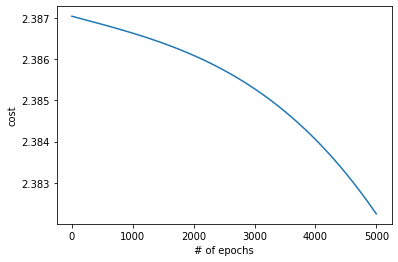

In [20]:
params = skipgram_model(x, y_oh, vocabulary_size, 100, 0.001, 5000, batch_size = 128, parameters = None, print_cost = True)

In [21]:
test = np.arange(vocabulary_size)
test = np.expand_dims(test, axis = 0)
output, cache = forward_prop(test, params)
sorted_index = np.argsort(output, axis = 0)[-4:, :]

In [26]:
for indx in range(vocabulary_size):
    input_word = index_to_word[indx]
    output_words = [index_to_word[output_ind] for output_ind in sorted_index[::-1, indx]]
    print("{}'s neighbor words: {}".format(input_word, output_words))

to's neighbor words: ['.', 'footballer', 'the', 'greatest']
pitch's neighbor words: ['.', 'footballer', 'the', 'greatest']
greatest's neighbor words: ['the', 'to', 'pitch', 'ever']
the's neighbor words: ['.', 'footballer', 'the', 'greatest']
.'s neighbor words: ['pitch', 'the', 'grace', 'ever']
grace's neighbor words: ['.', 'footballer', 'the', 'greatest']
footballer's neighbor words: ['pitch', 'the', 'grace', 'ever']
ever's neighbor words: ['.', 'footballer', 'the', 'greatest']
Messi's neighbor words: ['to', 'is', 'Lionel', 'the']
Lionel's neighbor words: ['footballer', '.', 'Messi', 'greatest']
is's neighbor words: ['ever', 'Lionel', 'grace', 'to']
